In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!pip install jamo

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 46.1 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-10-17 11:57:04--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings('ignore')

import re
import seaborn as sb

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, confusion_matrix
from jamo import h2j, j2hcj

import os

from gensim.models import FastText

In [73]:
def train_load():
  train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train_data.csv', encoding='cp949')
  train_data['comments'] = train_data['comments'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','')
  
  return train_data

def spliter(text):
    return j2hcj(h2j(text))

def tokenize(data, stopwords=stopwords):
  mecab = Mecab()
  train_tokenized = []

  for comment in data['comments']:
    temp_X = mecab.morphs(comment)
    temp_X = [spliter(word) for word in temp_X if not word in stopwords]
    train_tokenized.append(temp_X)
  
  return train_tokenized

def vectorize_data(data, vocab: dict) -> list:
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    
    return vectorized

def build_model(embedding_matrix: np.ndarray, maxlen: int):
    model = Sequential()
    model.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1],  input_length = input_length, weights = [embedding_matrix], trainable=False))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    return model

model = build_model(embedding_matrix=ft_model.wv.vectors, maxlen=max_len)

def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

def predict_proba(pred):
  proba = []
  for i in range(len(pred)):
    proba.append([float(1-y_train_pred[i]), y_train_pred[i][0]])
  
  return proba

def class_predict(proba):
  return np.argmax(proba, axis=1)

def predictor(text, vocab=ft_model.wv.vocab, maxlen=max_len, stopwords=stopwords):
  pattern = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣]')
  text = re.sub(pattern, ' ', text)
  mecab = Mecab()
  tokenized = mecab.morphs(text)
  tokenized = [token for token in tokenized if not token in stopwords]
  tokenized_split = [spliter(n) for n in tokenized]
  tokenized_padded = pad_sequences(sequences=vectorize_data(tokenized_split, vocab=vocab), maxlen=maxlen, padding='post')

  text = [spliter(text)]
  padded = pad_sequences(sequences=vectorize_data(text, vocab=vocab), maxlen=maxlen, padding='post')

  ratio = model.predict(padded)[0][0] * 100

  print(f'{ratio}%% 확률로 욕설 문장입니다.')
  print('----------------------------------------')
  print('욕설 부분 분석\n')
  for idx, token in enumerate(tokenized):
    print(token + ': ' + str(model.predict(tokenized_padded)[idx][0] * 100) +'% 확률로 욕설 부분') 


stopwords = ['에게', '를', '의', '로', '으로', '고', '하고', '듯', '인', '하는', '와', '과', '을', '들', '임', '게', '면', '가', '이가',
             '도', '마저', '한', '면', '네', '이', '는', '하', '다', '은', '지', '에', '거', '나', '보', '는데', '아', '나', '만', '에서',
             '음', '니', '냐', '만', '야', '요', '에요', '든', '걸', '이다', '건', '여']

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 50)           4885200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 150, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 146, 128)          32128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [82]:
train_data = train_load()
tokenized_data = tokenize(train_data, stopwords)
ft_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/model/fasttext_310k_spliter.model')
print('Data load complete.')

X_data = tokenized_data
max_len = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=ft_model.wv.vocab),
    maxlen=max_len,
    padding='post'
)
y_data = train_data['hate'].values

X_train, X_test, y_train, y_test = train_test_split(X_pad, y_data, test_size=0.15, shuffle=True, random_state=42)

print('Data preprocessing complete.')

model = build_model(embedding_matrix=ft_model.wv.vectors, maxlen=max_len)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=20)

print('Model train complete.')

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_pred_proba = predict_proba(y_train_pred)
test_pred_proba = predict_proba(y_test_pred)

train_preds = class_predict(train_pred_proba)
test_preds = class_predict(test_pred_proba)

print('Data predict complete.')


Data load complete.
Data preprocessing complete.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 50)           4885200   
_________________________________________________________________
dropout_13 (Dropout)         (None, 150, 50)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 146, 128)          32128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 36, 128)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense

In [89]:
text = '니네 뭐하냐? ㅆㅂ'
predictor(text)



42.81938374042511%% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

뭐: 11.187028884887695% 확률로 욕설 부분
ㅆㅂ: 34.45231914520264% 확률로 욕설 부분


In [91]:
model.save('/content/drive/MyDrive/Colab Notebooks/LM/ft_310k_spliter_simple_BiLSTM+1DCNN')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/LM/ft_310k_spliter_simple_BiLSTM+1DCNN/assets


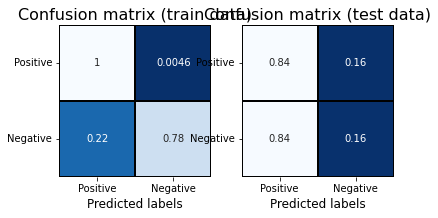

In [90]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, train_preds, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, test_preds, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])